# Salary Prediction Using Regression on MLB Data

In [192]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

## Data Analysis

Before plugging in the data into our SVM, it is important to evaluate redundant information to limit multicollinearity. We can find collinearities through the correlation matrix.

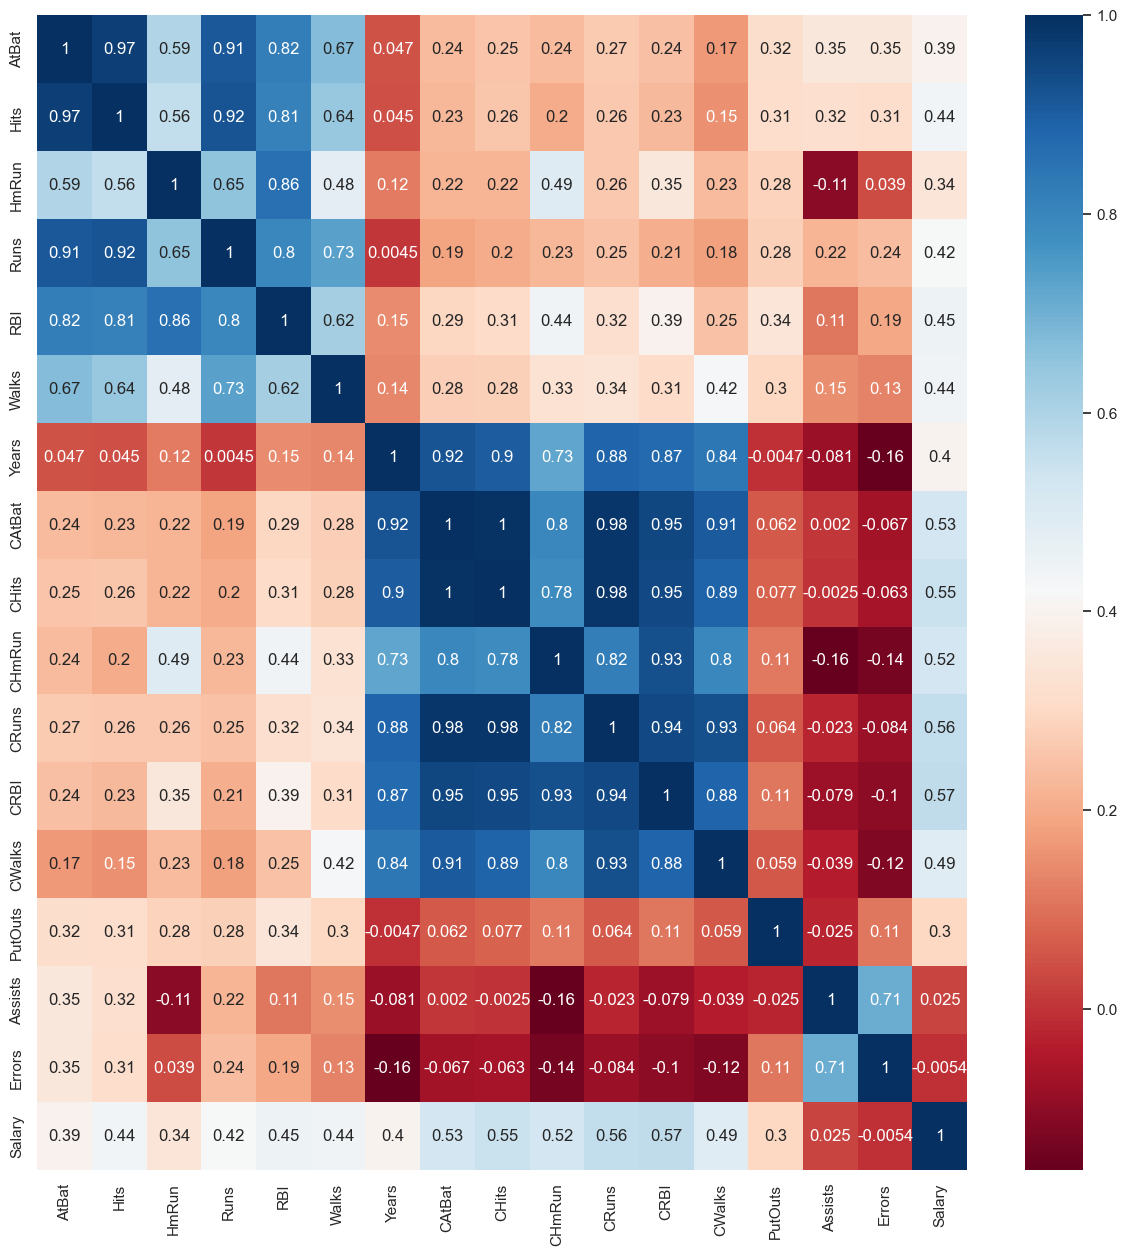

In [193]:
df = pd.read_csv("./Hitters.csv")
num_cols = [col for col in df.columns if df[col].dtypes != "O"]
corr = df[num_cols].corr()
sns.set(rc={'figure.figsize': (15, 15)})
sns.heatmap(corr, cmap="RdBu", annot=True)
plt.show()

### Run PCA on highly-correlated features

In [194]:
pca_custat = PCA(n_components=1)
pca_indstat = PCA(n_components=1)
pca_fieldstat = PCA(n_components=1)

custat_df = df[["CAtBat", "CHits", "CHmRun", "CRuns", "CRBI", "CWalks"]]
indstat_df = df[["AtBat", "Hits", "HmRun", "Runs", "RBI", "Walks"]]
fieldstat_df = df[["Assists", "Errors"]]

custat_df_pca = pca_custat.fit_transform(custat_df)
indstat_df_pca = pca_indstat.fit_transform(indstat_df)
fieldstat_df_pca = pca_fieldstat.fit_transform(fieldstat_df)

df_reduced = df.drop(columns=["AtBat", "Hits", "HmRun", "Runs", "RBI", "Walks", "CAtBat", "CHits", "CHmRun", "CRuns", "CRBI", "CWalks", "Assists", "Errors"])
df_reduced = df_reduced.drop(columns=["League", "NewLeague", "Division", "Years"])
df_reduced["I_PC1"] = indstat_df_pca
df_reduced["C_PC2"] = custat_df_pca
df_reduced["F_PC3"] = fieldstat_df_pca

# label_mapping_an = {'A': 0, 'N': 1}
# label_mapping_div = {'E': 0, 'W': 1}


# # Apply label encoding to the 'Category' column
# df_reduced['League'] = df_reduced['League'].map(label_mapping_an)
# df_reduced['NewLeague'] = df_reduced['NewLeague'].map(label_mapping_an)
# df_reduced['Division'] = df_reduced['Division'].map(label_mapping_div)
df_reduced.dropna(axis=0, inplace=True)

print(df_reduced)


     PutOuts  Salary       I_PC1        C_PC2       F_PC3
1        632   475.0   72.590869   801.168761  -63.814023
2        880   480.0 -108.738125 -1059.201154  -24.703570
3        200   500.0 -124.894681  3171.420761  -96.026925
4        805    91.5   63.304301 -2384.553500  -67.009725
5        282   750.0 -221.371087  1777.108228  314.474814
..       ...     ...         ...          ...         ...
317      325   700.0 -117.568310    61.626177  -98.025844
318      313   875.0 -122.303569  3049.912291  274.332014
319       37   385.0  -96.674458 -1030.222990    6.049449
320     1314   960.0 -201.645999   587.940371   24.204149
321      408  1000.0 -255.582377  2378.079204 -103.023139

[263 rows x 5 columns]


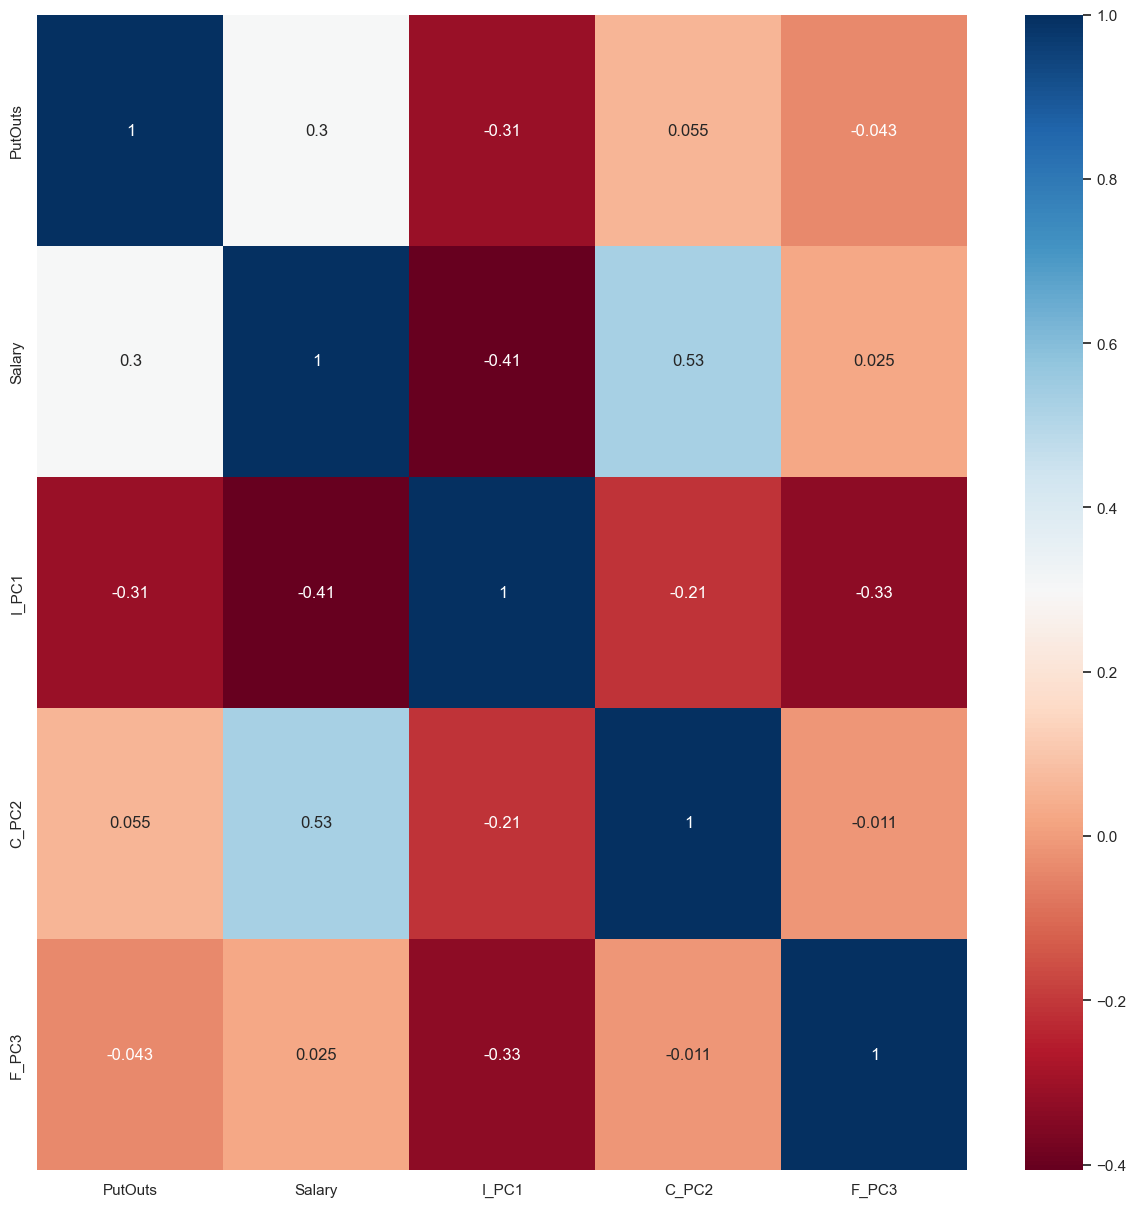

In [195]:
num_cols = [col for col in df_reduced.columns if df_reduced[col].dtypes != "O"]
corr = df_reduced[num_cols].corr()
sns.set(rc={'figure.figsize': (15, 15)})
sns.heatmap(corr, cmap="RdBu", annot=True)
plt.show()

we've reduced the data from 20 columns to 6 columns, which is important, as collinearity can negatively effect the preformance of regression models. Apart from the collinearity effect, I decided to get rid of discretely labeled binary relationships (labels 0 or 1), as this makes the linear regression model more complex and doesn't effect the model preformance that much.

### Create Training and Test Sets

Since we're trying to predict salary, I extract "salary" column from the dataframe, storing it into the label, and dropping that column from the feature data.

In [196]:
df = df_reduced
y = df["Salary"]
X = df.drop(columns="Salary")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

print(f"Salary STD: ${np.std(y) * 1000:,.2f}")
print(f"Salary Mean: ${np.mean(y) * 1000:,.2f}")
print(f"Salary Low: ${np.min(y) * 1000:,.2f}")
print(f"Salary High: ${np.max(y) * 1000:,.2f}")

Salary STD: $450,260.22
Salary Mean: $535,925.88
Salary Low: $67,500.00
Salary High: $2,460,000.00


## Linear Support Vector Regression (kernel="linear")

In [197]:
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train, y_train)
X_test_scaled = sc.fit_transform(X_test, y_test)
# pca_all = PCA(n_components=1)
# X_train_scaled_pca = pca_all.fit_transform(X_train_scaled)
# X_test_scaled_pca = pca_all.fit_transform(X_test_scaled)

svr_lin = SVR(kernel="linear", C=1, gamma="auto")
svr_lin.fit(X_train_scaled, y_train)
y_pred = svr_lin.predict(X_test_scaled)

### Visualize Multiple Linear Regression

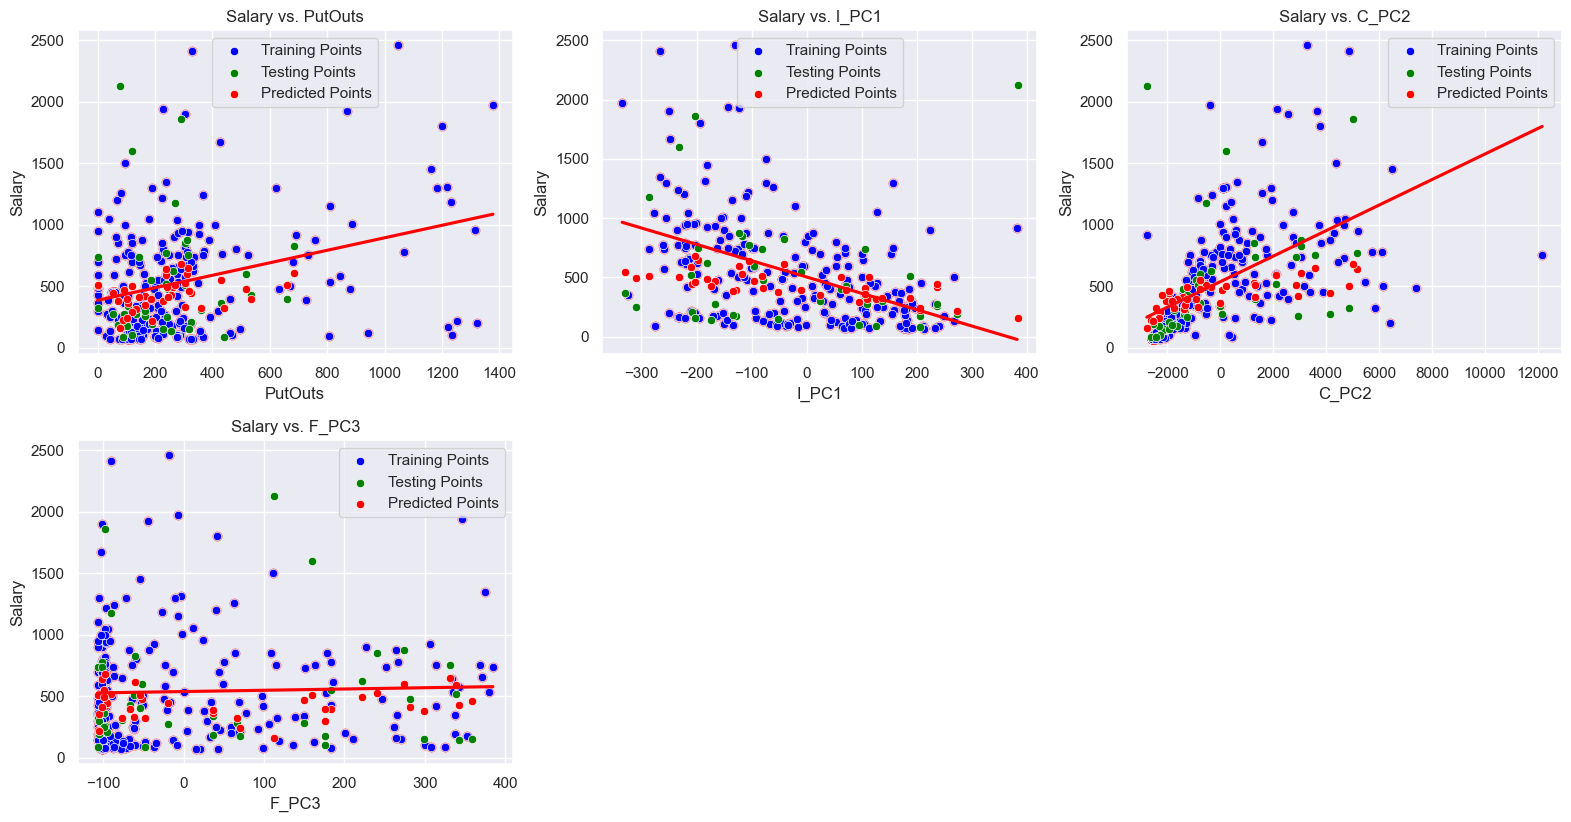

In [198]:
plt.figure(figsize=(16, 12))
independent_variables = X_train.columns
dependent_variable = "Salary"
X_test_numpy = X_test.to_numpy()
for i, col in enumerate(independent_variables, 1):
    plt.subplot(3, 3, i)
    sns.regplot(x=X_train[col],y=y_train,ci=None,color ='red')
    sns.scatterplot(data=X_train, x=col, y=y_train, color='blue', label='Training Points')
    sns.scatterplot(data=X_test, x=col, y=y_test, color='green', label='Testing Points')
    sns.scatterplot(data=X_test, x=col, y=y_pred, color='red', label='Predicted Points')
    plt.title(f'{dependent_variable} vs. {col}')
    plt.xlabel(col)
    plt.ylabel(dependent_variable)

plt.tight_layout()
plt.show()

In [199]:
result_df = pd.DataFrame(columns=["id", "actual", "predicted"])

for i, actual, predicted in zip(y_test.index, y_test, y_pred):
    entry = [i, actual, predicted]
    df_entry = pd.DataFrame(entry, index=["id", "actual", "predicted"]).T
    result_df = pd.concat((result_df, df_entry))
#print(result_df)
difference = abs(result_df["actual"] - result_df["predicted"])
print(f"Cumulative Difference: ${np.sum(difference) * 1000:,.2f}")
print(f"Min Difference: ${np.min(difference) * 1000:,.2f}")
print(f"Max Difference: ${np.max(difference) * 1000:,.2f}")
print(f"Average Difference: ${np.mean(difference) * 1000:,.2f}")
print(f"Std Difference: ${np.std(difference) * 1000:,.2f}")
print(f"Mean Squared Error: ${mean_squared_error(y_test, y_pred):,.2f}")


Cumulative Difference: $10,792,084.13
Min Difference: $19,061.95
Max Difference: $1,968,301.30
Average Difference: $269,802.10
Std Difference: $361,894.28
Mean Squared Error: $203,760.65


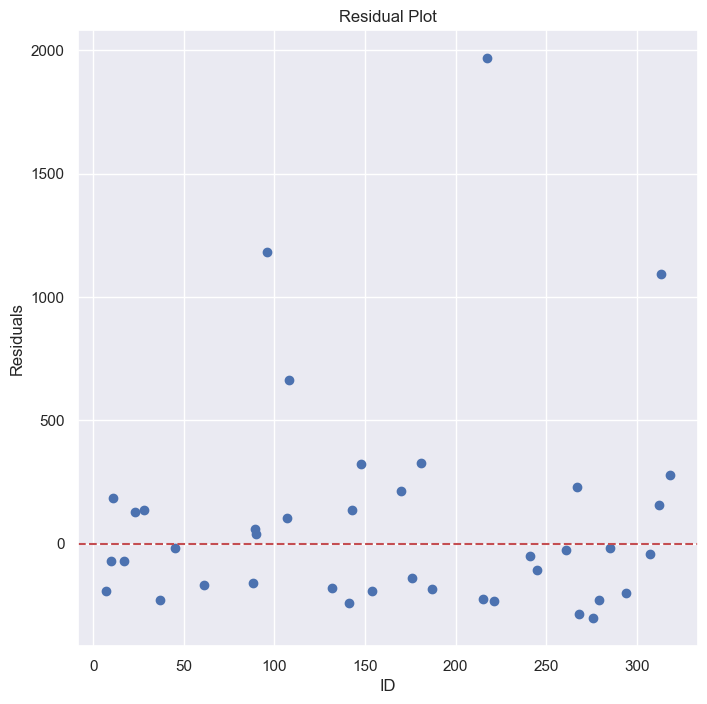

In [200]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(8,8))
residuals = result_df['actual'] - result_df['predicted']

plt.scatter(result_df['id'], residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('ID')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## Non-Linear Support Vector Regression (kernel="poly")

In [201]:
svr_poly = SVR(kernel="poly", degree=2, C=75, gamma="scale")
svr_poly.fit(X_train_scaled, y_train)
y_pred = svr_poly.predict(X_test_scaled)

result_df = pd.DataFrame(columns=["id", "actual", "predicted"])

for i, actual, predicted in zip(y_test.index, y_test, y_pred):
    entry = [i, actual, predicted]
    df_entry = pd.DataFrame(entry, index=["id", "actual", "predicted"]).T
    result_df = pd.concat((result_df, df_entry))
    
#print(result_df)
difference = abs(result_df["actual"] - result_df["predicted"])
print(f"Cumulative Difference: ${np.sum(difference) * 1000:,.2f}")
print(f"Min Difference: ${np.min(difference) * 1000:,.2f}")
print(f"Max Difference: ${np.max(difference) * 1000:,.2f}")
print(f"Average Difference: ${np.mean(difference) * 1000:,.2f}")
print(f"Std Difference: ${np.std(difference) * 1000:,.2f}")
print(f"Mean Squared Error: ${mean_squared_error(y_test, y_pred):,.2f}")

Cumulative Difference: $13,385,640.30
Min Difference: $798.03
Max Difference: $1,581,505.51
Average Difference: $334,641.01
Std Difference: $330,986.90
Mean Squared Error: $221,536.94


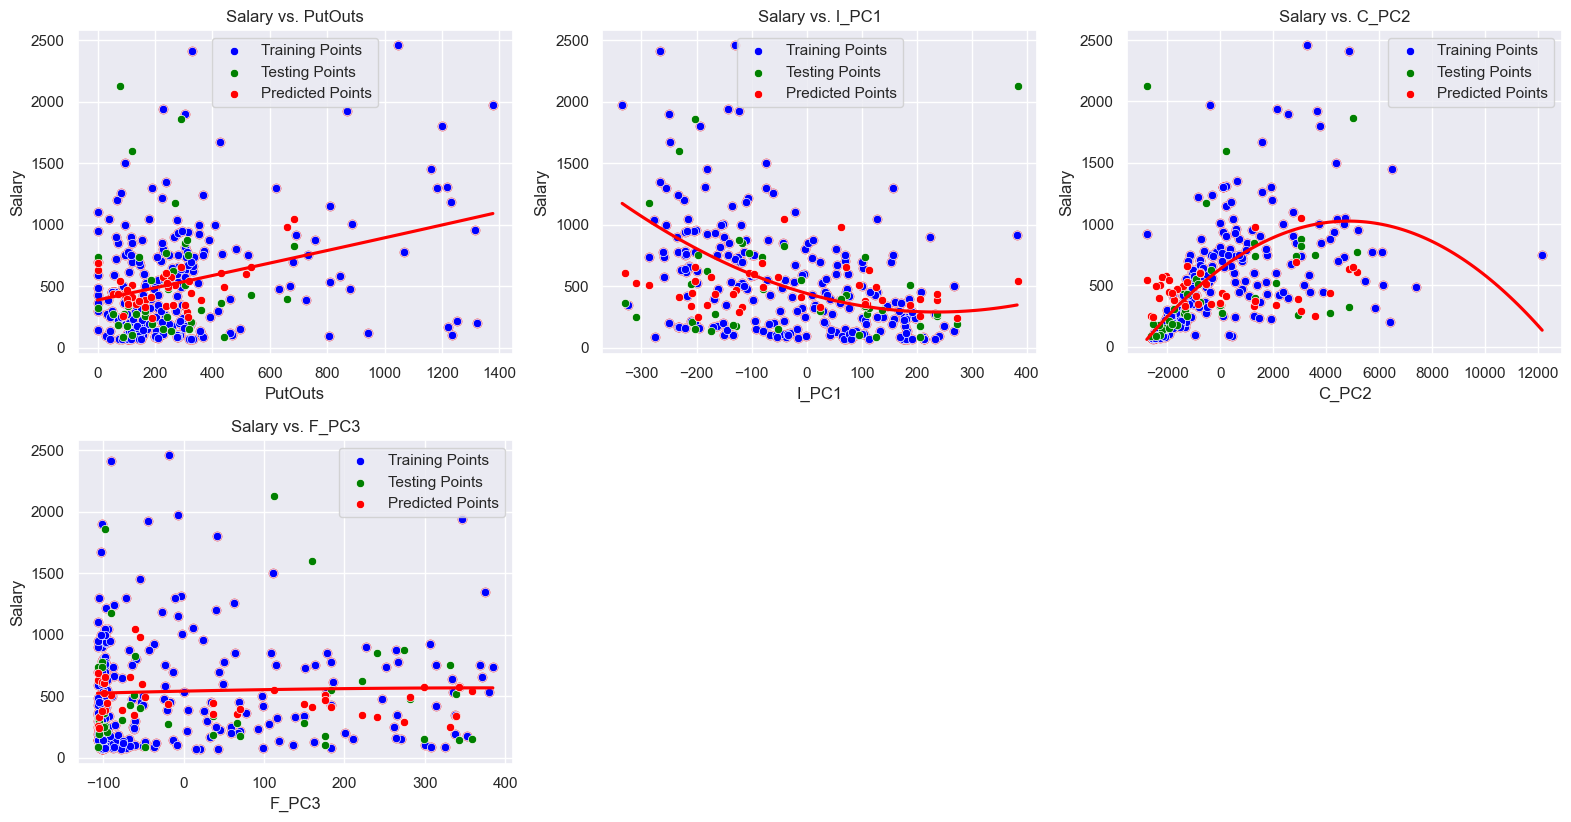

In [204]:
plt.figure(figsize=(16, 12))
independent_variables = X_train.columns
dependent_variable = "Salary"
X_test_numpy = X_test.to_numpy()
for i, col in enumerate(independent_variables, 1):
    plt.subplot(3, 3, i)
    sns.regplot(x=X_train[col],y=y_train,ci=None,color ='red', order=svr_poly.degree)
    sns.scatterplot(data=X_train, x=col, y=y_train, color='blue', label='Training Points')
    sns.scatterplot(data=X_test, x=col, y=y_test, color='green', label='Testing Points')
    sns.scatterplot(data=X_test, x=col, y=y_pred, color='red', label='Predicted Points')
    plt.title(f'{dependent_variable} vs. {col}')
    plt.xlabel(col)
    plt.ylabel(dependent_variable)

plt.tight_layout()
plt.show()

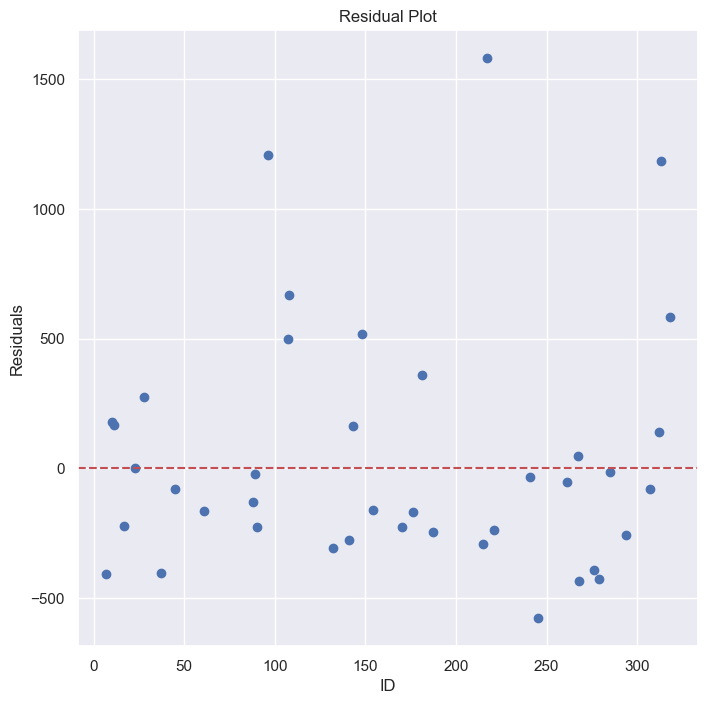

In [203]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(8,8))
residuals = result_df['actual'] - result_df['predicted']

plt.scatter(result_df['id'], residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('ID')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()